### Importing necessary libraries

In [356]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

### Loading the data

In [357]:
df = pd.read_csv('Customer_Churn_Dataset.csv')

Exploratory Data Analysis

In [358]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes


In [359]:
df.shape

(7043, 23)

In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Initially, let's convert the totalcharges column to a numeric column as it has currently been saved as an object

In [361]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

In [362]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets
count,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441,0.515689,0.419566
std,0.368612,24.559481,30.090047,2266.771362,1.275299,1.250117
min,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,401.450000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000,0.000000
75%,0.000000,55.000000,89.850000,3794.737500,0.000000,0.000000
max,1.000000,72.000000,118.750000,8684.800000,5.000000,9.000000


A lot of information can be inferred from this. It can be seen that the mean for the senior citizen variable is 0.16 showing that only around 16% of the total customers belong to that age range. It can also be seen that the monthly charges are between 18 and 118 suggesting not a huge range or discrepancy between minimum and maximum.

In [363]:
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
numAdminTickets      0
numTechTickets       0
Churn                0
dtype: int64

In [364]:
df.duplicated().sum()

np.int64(0)

In [365]:
df = df.drop(columns =['customerID'],axis=1)

Visualisations

In [366]:
num_cols = df.select_dtypes(include=['int64','float64'])
num_cols.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets
0,0,1,29.85,29.85,0,0
1,0,34,56.95,1889.50,0,0
2,0,2,53.85,108.15,0,0
3,0,45,42.30,1840.75,0,3
4,0,2,70.70,151.65,0,0


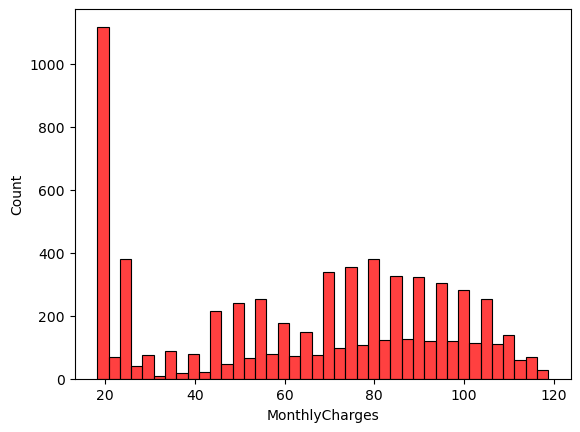

In [367]:
sns.histplot(num_cols['MonthlyCharges'],bins=40,color='red')
plt.show()

Most monthly charges tend to be around 20 while there are some small spikes where larger charges to the customers are present as well. 

#### Checking for outliers

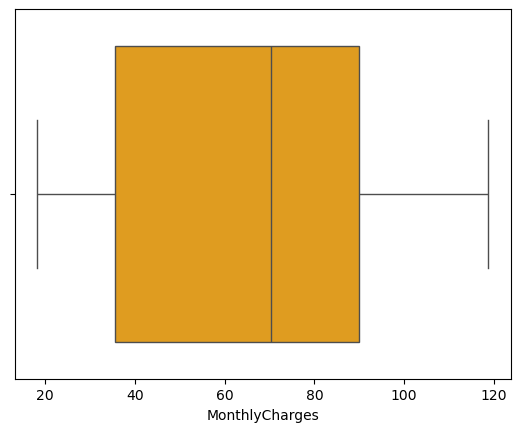

In [368]:
sns.boxplot(x=num_cols['MonthlyCharges'],color='orange')
plt.show()

As expected, there are no customers that are charged an amount enough to be deemed as an outlier. 

In [369]:
q1 = num_cols['MonthlyCharges'].quantile(0.25)
q3 = num_cols['MonthlyCharges'].quantile(0.75)
IQR = q3-q1
lower = q1 - 1.5 * IQR
upper = q3 - 1.5 * IQR
print(q1, q3, lower, upper)
print(df['MonthlyCharges'].min(), df['MonthlyCharges'].max())
outliers = num_cols[(num_cols['MonthlyCharges'] < lower) | (num_cols['MonthlyCharges'] > upper)]


35.5 89.85 -46.02499999999999 8.325000000000003
18.25 118.75


No outliers

Preprocessing 

In [370]:
cat_cols = df.select_dtypes(include = ['object'])
for col in cat_cols.columns:
    a = cat_cols[col].value_counts()
    print(col,': \n',a,'\n')

gender : 
 gender
Male      3555
Female    3488
Name: count, dtype: int64 

Partner : 
 Partner
No     3641
Yes    3402
Name: count, dtype: int64 

Dependents : 
 Dependents
No     4933
Yes    2110
Name: count, dtype: int64 

PhoneService : 
 PhoneService
Yes    6361
No      682
Name: count, dtype: int64 

MultipleLines : 
 MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64 

InternetService : 
 InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64 

OnlineSecurity : 
 OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64 

OnlineBackup : 
 OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64 

DeviceProtection : 
 DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int

In [371]:
x = df.drop('Churn',axis=1)
y = df['Churn']

In [372]:
cat_cols_one_hot = x.select_dtypes(include='object').columns.tolist()
cat_cols_one_hot.remove('Contract')
cat_cols_label = ['Contract']

In [373]:
num_col = x.select_dtypes(include = ['float64', 'int64']).columns.tolist()

K-fold cross validation with k = 5 will be used in order to perform cross-validation on the model to ensure it's consistency.

In [374]:
kf = KFold(n_splits=5, shuffle=True,random_state=42)
score = []

In [375]:
for train_idx, val_idx in kf.split(x):

    x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


Both label encoder and One Hot encoder will be used on the dataset to convert the categorical columns into numerical ones. This decision is based on a willful choice to only use the Label Encoder on the contract column as it has ordinal labels and One Hot encoder on the rest of the variables. 

In [376]:
label_encoder = LabelEncoder()
x_train_contract = label_encoder.fit_transform(x_train['Contract'])
x_val_contract = label_encoder.transform(x_val['Contract'])

In [377]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
x_train_cat = one_hot_encoder.fit_transform(x_train[cat_cols_one_hot])
x_val_cat = one_hot_encoder.transform(x_val[cat_cols_one_hot])

In [378]:
num_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SeniorCitizen    7043 non-null   int64  
 1   tenure           7043 non-null   int64  
 2   MonthlyCharges   7043 non-null   float64
 3   TotalCharges     7032 non-null   float64
 4   numAdminTickets  7043 non-null   int64  
 5   numTechTickets   7043 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 330.3 KB


In [380]:
scaler = StandardScaler()
x_train_num = scaler.fit_transform(x_train[num_col])
x_val_num = scaler.transform(x_val[num_col])

In [403]:
x_train_num.shape

(5635, 6)

In [404]:
X_train = np.hstack([x_train_num,x_train_cat,x_train_contract])

X_val = np.hstack([x_val_num,x_val_contract,x_val_cat])

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [ ]:
print(type(x_train_num), x_train_num.shape)
print(type(x_train_cat), x_train_cat.shape)
print(type(x_train_contract), x_train_contract.shape)


<class 'numpy.ndarray'> (5635, 6)
<class 'numpy.ndarray'> (5635, 38)
<class 'numpy.ndarray'> (5635, 1)


In [410]:
b = np.array([[4],[5],[6]])
a = np.array([[1],[2],[3], [4]])
np.hstack(a,b)

TypeError: hstack() takes 1 positional argument but 2 were given

In [ ]:
x_train_cat = x_train_cat.toarray()
x_val_cat = x_val_cat.toarray()


Modelling

In [ ]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_val)
precision = precision_score(y_pred,y_val)
recall = recall_score(y_pred,y_val)
accuracy = accuracy_score(y_pred,y_val)
print('Precision :',precision,'Recall :',recall,'accuracy :',accuracy)


ValueError: pos_label=1 is not a valid label. It should be one of ['No', 'Yes']